# Decision tree

There is a group of statistical models based on the *decision tree* algorithm. This page discusses these algorithms.

Findout more in:

- [Introduction to statistical learning](https://www.statlearning.com/).
- Many useful information in [Decision Trees](https://scikit-learn.org/stable/modules/tree.html#decision-trees) page of the official documentation.

In [4]:
import graphviz
from IPython.display import Markdown

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt

import sklearn.tree as tree
from sklearn.inspection import DecisionBoundaryDisplay

from decision_tree.prog import plot_Q_scatter

## Tree model

A decision tree can be used to solve both regression and classification tasks. The idea is to split the original predictor space into regions ($R_1, R_2, \dots, R_m$), where a prediction is made for each region $R_i$ based on the observations within it.

For example, in a regression task, the mean response value can be predicted for the selected region. In the following example, a decision tree is shown that could be formed for data corresponding to a paraboloid.

The graph at the top illustrates the decision-making process, while the diagrams below show how predictions were formed.

- The nodes in the graph where decisions are made are called **internal nodes**.
- The nodes in the graph that produce the final result and correspond to $R_i$ are called **terminal nodes or leaves**.

---

As an example, consider the approximation of a two-dimensional function whose observed values are represented as a table. We'll use `sklearn.tree.DecisionTreeRegressor` to build a model that will serve as our example.

In [8]:
# Fitting sample
sample_size = 500
np.random.seed(30)

x1_lim = [-5, 5]
x2_lim = [-5, 5]

sample_df = pd.DataFrame({
    "x_1" : np.random.uniform(*x1_lim, sample_size),
    "x_2" : np.random.uniform(*x2_lim, sample_size),
})

sample_df["y"] = sample_df["x_1"]**2 + sample_df["x_2"]**2
display(sample_df.head(10))

# Model fitting
my_first_tree = tree.DecisionTreeRegressor(max_depth=2).fit(
    sample_df[["x_1", "x_2"]],
    sample_df["y"]
)

,x_1,x_2,y
0,1.441435,-1.070229,3.223126
1,-1.192515,-3.611707,14.466518
2,1.630479,0.776403,3.261264
3,-3.363493,-2.752743,18.890680
4,4.626078,-3.102737,31.027577
5,-1.533382,-3.299123,13.235470
6,4.917510,-1.395313,26.128801
7,-2.649421,0.363438,7.151519
8,0.856943,-4.047606,17.117462
9,-0.933099,-0.801175,1.512554


The following cell visualizes the decision tree. Each node splits the data into two subsets, with each subset being further divided by the subsequent nodes.

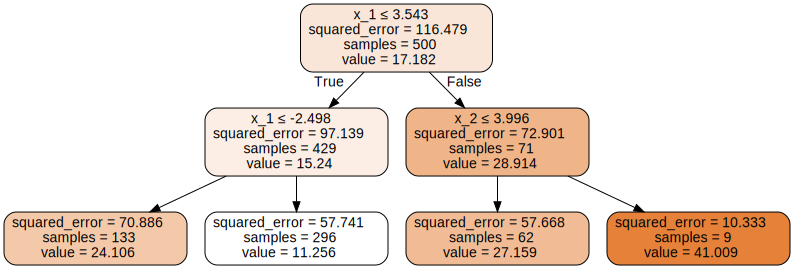

In [10]:
# Visualisation of the tree
dot_data = tree.export_graphviz(
    my_first_tree, 
    out_file=None,
    feature_names = ["x_1", "x_2"],
    filled=True, 
    rounded=True,  
    special_characters=True
)
graph = graphviz.Source(dot_data)
graph

The output of the same model is represented as a set of sectors on the $x_1$-$x_2$ surface.

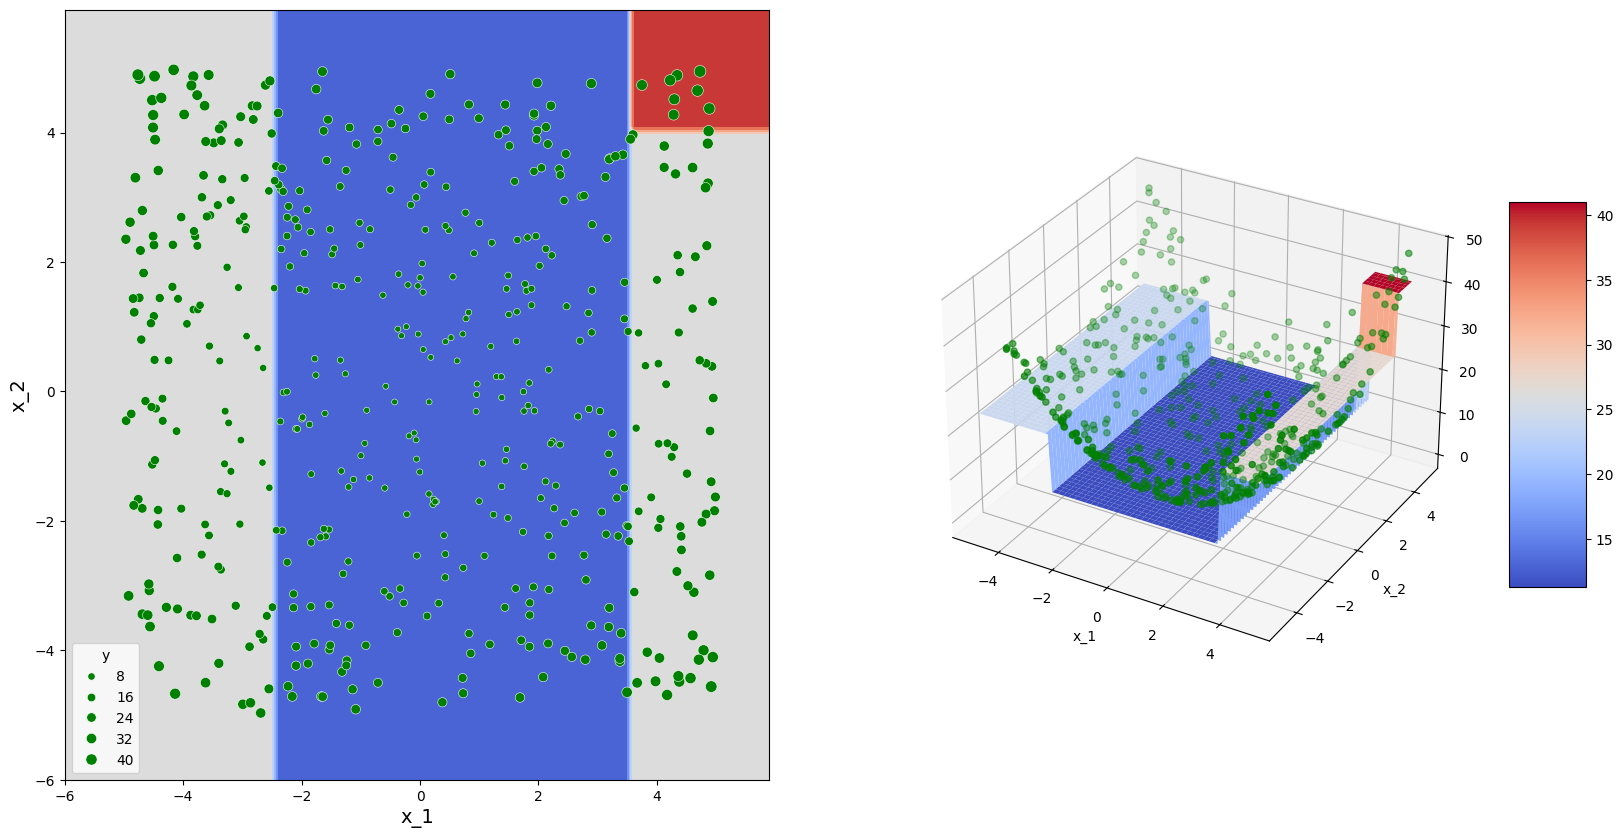

In [12]:
fig = plt.figure(figsize = [20, 10])

# Predictions grid
x1_range = np.arange(*x1_lim, 0.1)
x2_range = np.arange(*x2_lim, 0.1)
x1_mesh, x2_mesh = np.meshgrid(x1_range, x2_range)
mesh_df = pd.DataFrame({
    "x_1" : x1_mesh.ravel(),
    "x_2" : x2_mesh.ravel()
})
p_mesh = np.reshape(
    my_first_tree.predict(mesh_df),
    x1_mesh.shape
)

# Visualisation of the decision surface
ax1 = fig.add_subplot(121)
DecisionBoundaryDisplay.from_estimator(
    my_first_tree,
    mesh_df,
    cmap=cm.coolwarm,
    response_method="predict",
    ax = ax1,
)
sns.scatterplot(
    data = sample_df,
    x = "x_1", y = "x_2",
    size = "y",
    ax=ax1,
    color = "green"
)
plt.xlabel("x_1", fontsize = 14)
plt.ylabel("x_2", fontsize = 14)

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(
    sample_df["x_1"],
    sample_df["x_2"],
    sample_df["y"],
    color = "green"
)
surf = ax2.plot_surface(
    x1_mesh, x2_mesh, p_mesh,
    cmap=cm.coolwarm
)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.xlabel("x_1"); plt.ylabel("x_2");

## Fitting procedure

Such group of models usually uses so called "gready search" approaches for fitting. At each step it tries all possible separations and select the best according to the chosen role.

Check [different implementations](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) of the algorithm listed in sklearn. We'll consider more carefully approch used by sklearn implementations, check offical description [here](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation).

---

At each step of the algorithm, you need to choose the best separation according to the given data. We'll consider an example so simple that you can find the best separation by hand. But we'll look at the best option.

The following cell creates set of points that we'll use as example.

|    |   x_1 |   x_2 |   y |
|---:|------:|------:|----:|
|  0 |   1   |   1.5 |   0 |
|  1 |   5   |   2.5 |   0 |
|  2 |   6   |   2   |   1 |
|  3 |   5.5 |   1   |   0 |
|  4 |   6.5 |   3   |   1 |
|  5 |   8   |   3.5 |   1 |
|  6 |   8.5 |   4   |   1 |

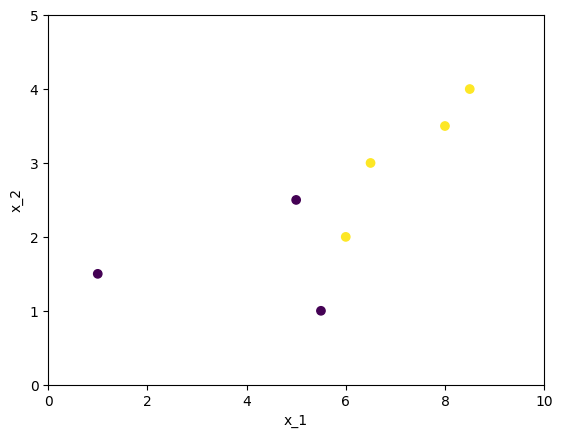

In [13]:
X = pd.DataFrame({
    "x_1": [1,     5, 6, 5.5, 6.5,   8, 8.5],
    "x_2": [1.5, 2.5, 2,   1,   3, 3.5,   4],
    "y":   [0,     0, 1,   0,   1,   1,   1]
})
display(Markdown(X.to_markdown()))

plot_Q_scatter(
    x=X["x_1"], y=X["x_2"], c=X["y"],
    arrange=(0, 10, 0, 5)
)
plt.show()

Consider three different separations. Each separation forms two subsets of the observation $Q^{left}$ and $Q^{right}$.

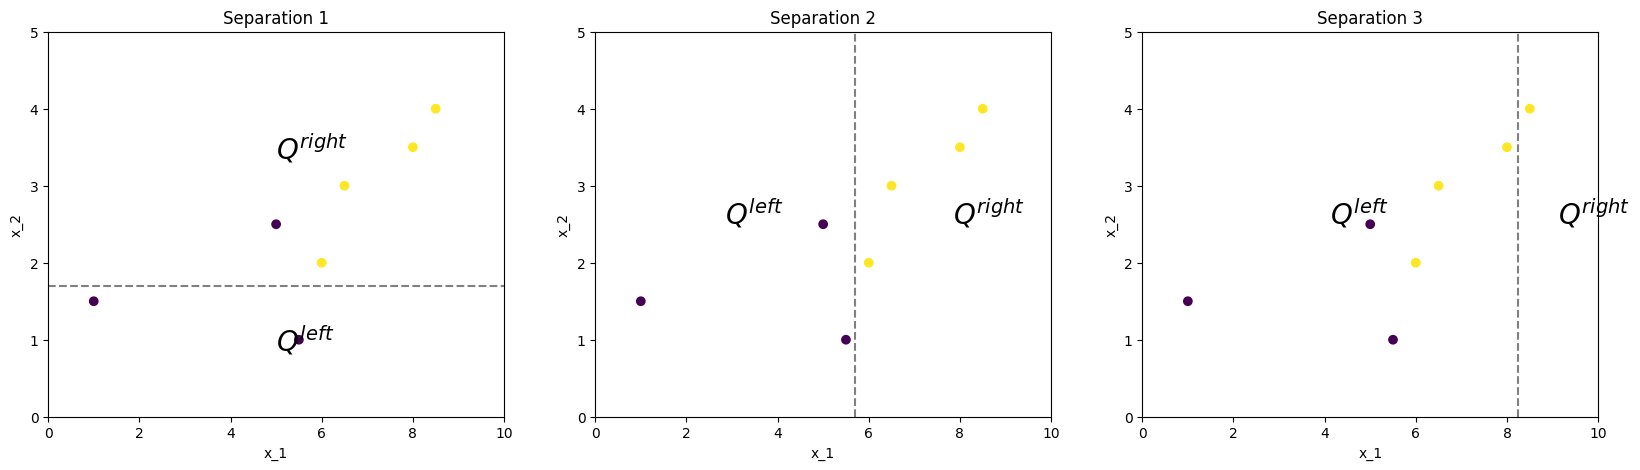

In [14]:
plt.figure(figsize=(20, 5))

plt.subplot(131)
plot_Q_scatter(
    x=X["x_1"], y=X["x_2"], c=X["y"],
    arrange=(0, 10, 0, 5),
    sep_orient="h",
    sep_val=1.7
)
plt.title("Separation 1")

plt.subplot(132)
plot_Q_scatter(
    x=X["x_1"], y=X["x_2"], c=X["y"],
    arrange=(0, 10, 0, 5),
    sep_orient="v",
    sep_val=5.7
)
plt.title("Separation 2")

plt.subplot(133)
plot_Q_scatter(
    x=X["x_1"], y=X["x_2"], c=X["y"],
    arrange=(0, 10, 0, 5),
    sep_orient="v",
    sep_val=8.25
)
plt.title("Separation 3")

plt.show()

Obviously, *Separation 2* is the best, since it ideally separates observations according to their real classes. Now we'll study how to get the same result formally.

There are functions that allow us to estimate the homogeneity of an observation subset: $Q$. For different tasks, $H(Q)$ can be defined differently, but we will focus on the Gini coefficient:

$$H(Q) = \sum_{k=1}^K p_{k}(1-p_{k})$$

Where $p_{k}$ is the fraction of observations of the $k$-th class in $Q$:

$$p_{k} = \frac{1}{n} \sum_{y \in Q} I(y=k)$$

- $n$: number of observations.
- $I(y=k)$: takes value 1 if $y=k$ and 0 otherwise.
- $K$: number of classes.

The following cell computes and displays the $H(Q^{left}(i))$ and $H(Q^{right}(i))$ coefficients, where $i$ is the separation number. So for the example under consideration:

$$
H(Q^{left}_1) = 0.0; H(Q^{right}_1) = 0.32\\
H(Q^{left}_2) = 0.0; H(Q^{right}_2) = 0.0\\
H(Q^{left}_3) = 0.5; H(Q^{right}_3) = 0.0
$$

In [15]:
def H(y: np.ndarray, Q: np.ndarray) -> float:
    p_vals = [(y[Q] == 1).mean(), (y[Q] == 0).mean()]
    return sum([p * (1 - p) for p in p_vals])


y=X["y"].to_numpy()

Q_options = [
    X["x_2"] < 1.7,
    X["x_1"] < 5.7,
    X["x_1"] < 8.25
]

for i, Q_left in enumerate(Q_options):
    Q_left = Q_left.to_numpy()
    H_left = H(y=y, Q=Q_left)
    H_right = H(y=y, Q=~Q_left)

    display(Markdown(
        f"H(Q^{{left}}_{i + 1}) = {H_left}; "
        f"H(Q^{{right}}_{i + 1}) = {H_right}"
    ))

H(Q^{left}_1) = 0.0; H(Q^{right}_1) = 0.32

H(Q^{left}_2) = 0.0; H(Q^{right}_2) = 0.0

H(Q^{left}_3) = 0.5; H(Q^{right}_3) = 0.0

The more homogeneous the observations in the subset $Q_i$ - which is generally favorable for us - the smaller the value of $H(Q_i)$.

To estimate the total quality of a separation (so called "impurity"), scikit-learn uses the following formula:

$$G(Q, i) = \frac{n^{left}}{n}H(Q^{left}(i)) + \frac{n^{right}}{n}H(Q^{right}(i))$$

Here, $n^{left} = |Q^{left}|$ and $n^{right} = |Q^{right}|$.

This represents the weighted mean of the homogeneity measures for the two subsets, weighted by the number of observations in each subset.

Finally you just have to select separation with the smallest impurity $i^* = argmin_i(G(Q,i))$.

## Feature importance

Models based on the decision tree algorithm allow for the calculation of `feature_importances_`. This value characterizes how often a feature was used in different nodes of the tree.

---

The following cell generates $X$ and $y$ such that each next feature influences $y$ more than the previous one. Fits the decision tree to it and estimates the importance of the features.

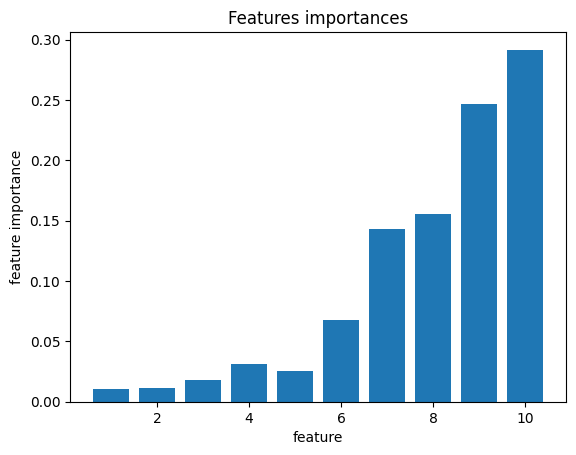

In [16]:
features_count = 10
sample_size = 500

X = np.random.uniform(-5, 5, (sample_size, features_count))

y = (X @ np.arange(features_count))

model = tree.DecisionTreeRegressor(
    max_depth=10
).fit(X=X, y=y)

plt.bar(range(1, features_count + 1), model.feature_importances_)
plt.xlabel("feature"), plt.ylabel("feature importance")
plt.title("Features importances")
plt.show()

As a result, the feature importance for the feature we designed to have a greater influence on the target is higher.